In [3]:
from langchain_groq import ChatGroq
from langgraph.checkpoint.memory import MemorySaver, InMemorySaver
from langchain_huggingface import HuggingFaceEmbeddings
from langgraph.graph import END, StateGraph, START
from langchain_community.vectorstores import FAISS
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from typing import Literal, List, Annotated, Sequence
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages
from langchain.tools.retriever import create_retriever_tool
from langgraph.prebuilt import tools_condition, ToolNode
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from dotenv import load_dotenv
import uuid
import os
from pprint import pprint

In [4]:
load_dotenv()

True

In [5]:
groq_api_key = os.getenv("GROQ_API_KEY")
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["HF_TOKEN"] = os.getenv("HF_TOKEN")

In [6]:
embeddings_model = HuggingFaceEmbeddings(model_name='all-MiniLM-L6-v2')

/home/codespace/.python/current/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
vectorstore = FAISS.load_local("/workspaces/ARAG-with-CrewaiWebScrape/faiss_index", embeddings_model, allow_dangerous_deserialization=True)
retriever = vectorstore.as_retriever(search_kwargs={"k": 3})

In [8]:
retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_genie_business_context",
    "Search and return context information about, 'genie business', payment solutions, fintech, tap to pay, qr online transactions and business related information"
)

tools = [retriever_tool]

In [9]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    is_small_talk: bool

### Edges

In [41]:
def small_talk(state) -> Literal["agent", "generate"]:
    """
    Determines whether the question is small talk or not.

    Args:
        state (messages): The current state

    Returns:
        str: A decision for whether the question is small talk or not
    """
    print("---CHECK Small-Talk---")
    print("STATE:", state)
    class grade(BaseModel):
        """Binary score for relevance check."""
        binary_score: Literal["yes","no"] = Field(description="Relevance score 'yes' or 'no'")

    model = ChatGroq(model=os.getenv("LLM_MODEL", "llama3-70b-8192"), api_key=groq_api_key, streaming=True)

    llm_with_structured = model.with_structured_output(grade)

    classification_prompt = PromptTemplate(
        template="""
        Classify the following user input as either 'small talk' or 'business-related inquiry'.
        Return "yes" if business-related-inquiries", else retun "yes"
        
        User input: {question}
        """,
        input_variables=["question"]
    )

    messages = state["messages"]
    question = messages[0].content


    chain = classification_prompt|llm_with_structured

    answer=chain.invoke({"question": question})
    score = answer.binary_score

    if score == "no":
        print("---DECISION: Small Talk---")
        state["is_small_talk"] = True
        return "generate"

    else:
        print("---DECISION: Not Small Talk---")
        state["is_small_talk"] = False
        return "agent"

In [42]:
def grade_documents(state) -> Literal["generate", "rewrite"]:
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (messages): The current state

    Returns:
        str: A decision for whether the documents are relevant or not
    """
    print("---CHECK RELEVANCE---")
    print("STATE:", state)
    class grade(BaseModel):
        """Binary score for relevance check."""
        binary_score: Literal["yes","no"] = Field(description="Relevance score 'yes' or 'no'")

    model = ChatGroq(model=os.getenv("LLM_MODEL", "llama3-70b-8192"), api_key=groq_api_key, streaming=True)

    llm_with_tools = model.with_structured_output(grade)

    # Prompt
    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )

    #chain
    chain = prompt|llm_with_tools

    messages = state["messages"]
    docs = messages[-1].content
    question = messages[0].content

    score_results = chain.invoke({"question": question,"context": docs})

    score = score_results.binary_score

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generate"

    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        print(score)
        return "rewrite"


### Nodes

In [52]:
def agent(state):
    """
    Invokes the agent model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply end.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the agent response appended to messages
    """
    print("---CALL AGENT---")
    print("STATE:", state)
    messages = state["messages"]
    question = messages[0].content

    model = ChatGroq(model=os.getenv("LLM_MODEL", "llama-3.1-8b-instant"), api_key=groq_api_key)

    model_with_tools = model.bind_tools(tools)
    response = model_with_tools.invoke(messages)
    return {"messages":messages + [response]}



In [59]:
def rewrite(state):
    """
    Transform the query to produce a better question.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with re-phrased question
    """

    print("---TRANSFORM QUERY---")
    print("STATE:", state)
    messages = state["messages"]
    question = messages[0].content

    msg = [
        HumanMessage(
            content=f""" \n 
    Look at the input and try to reason about the underlying semantic intent / meaning. \n 
    Here is the initial question:
    \n ------- \n
    {question} 
    \n ------- \n
    Formulate an improved question: """,
        )
    ]
    model = ChatGroq(model=os.getenv("LLM_MODEL", "llama3-70b-8192"), api_key=groq_api_key, streaming=True)
    response = model.invoke(msg)
    return {"messages": messages + [response]}

In [71]:
def generate(state):
    """
    Generate answer

    Args:
        state (messages): The current state

    Returns:
         dict: The updated state with re-phrased question
    """
    print("---GENERATE---")
    print("STATE:", state)
    messages = state["messages"]
    question = messages[0].content
    docs = messages[-1].content

    model = ChatGroq(model=os.getenv("LLM_MODEL", "llama-3.1-8b-instant"), api_key=groq_api_key)

    generate_prompt = PromptTemplate(
        template="""You are a customer service assistant for 'Genie Business' called 'Ashen' for question-answering tasks. \n
        You are always giving answers to a merchant who is looking to get information. \n
        Use the following pieces of retrieved context to answer the question. \n
        If you don't know the answer, just say that you don't know. \n
        Use simpler and keep the answer short but detailed and answer concise. \n
        Here is the context: \n\n {context} \n\n
        Here is the user question: {question} \n""",
        input_variables=["context", "question"],
    )

    small_talk_prompt = PromptTemplate(
        template="""
        You are a customer service assistant for 'Genie Business' called 'Ashen' for question-answering tasks. \n
        You are always giving answers to a merchant who is looking to get information.
        
        User input: {question}
        """,
        input_variables=["question"]
        )
    if state.get("is_small_talk", True):
        print("---Generating Small-Talk---")
        normal_chain = small_talk_prompt|model|StrOutputParser()
        response = normal_chain.invoke({"question":question})
        return {"messages":messages + [response]}
    else:
        # Post-processing
        def format_docs(docs):
            return "\n\n".join(doc.page_content for doc in docs)
        
        rag_chain = generate_prompt | model | StrOutputParser()
        response = rag_chain.invoke({"context": format_docs(docs), "question":question})
        return {"messages": messages + [response]}

### Graph

In [72]:
#Define graph
workflow = StateGraph(AgentState)

#Define nodes
workflow.add_node("agent", agent)
retrieve = ToolNode([retriever_tool])
workflow.add_node("retrieve", retrieve)
workflow.add_node("rewrite", rewrite)
workflow.add_node("generate", generate)

#Start node
workflow.add_conditional_edges(
    START,
    small_talk,
)
#Edges
workflow.add_conditional_edges(
    "agent",
    tools_condition,
    {
        "tools": "retrieve",
        END: END,
    },
)
workflow.add_conditional_edges(
    "retrieve",
    grade_documents,
)
workflow.add_edge("rewrite","agent")
#End node
workflow.add_edge("generate",END)
#Compile
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)

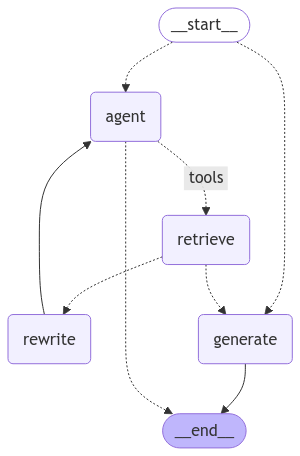

In [62]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [73]:
thread_id = str(uuid.uuid4())
config = {
    "configurable": {
        "thread_id": thread_id
    }
}
thread_id

'd015f309-65b4-4513-a6c1-a8b471fad4ef'

In [ ]:
inputs = {
    "messages": [HumanMessage(content="Can you tell me about Genie Business?"),]
}
for output in graph.stream(inputs,config=config):
    for key, value in output.items():
        pprint(f"Output from node '{key}':")
        pprint("---")
        pprint(value, indent=2, width=80, depth=None)
    pprint("\n---\n")

In [74]:
inputs = {
    "messages": [
        HumanMessage(content="Hi"),
        AIMessage(content="I'm here to help!"),
        HumanMessage(content="Can you tell me about Genie Business?")
    ]
}

for output in graph.stream(inputs, config=config):
    for key, value in output.items():
        pprint(f"Output from node '{key}':")
        pprint("---")
        pprint(value, indent=2, width=80, depth=None)
    pprint("\n---\n")

---CHECK Small-Talk---
STATE: {'messages': [HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}, id='88f0ff78-7fd2-4463-a919-9689dd309a3f'), AIMessage(content="I'm here to help!", additional_kwargs={}, response_metadata={}, id='aeaa935d-81ce-482c-890b-0ffef2c4a19c'), HumanMessage(content='Can you tell me about Genie Business?', additional_kwargs={}, response_metadata={}, id='e58d6e83-f925-4735-b1ab-8665e48cba38')]}


---DECISION: Not Small Talk---
---CALL AGENT---
STATE: {'messages': [HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}, id='88f0ff78-7fd2-4463-a919-9689dd309a3f'), AIMessage(content="I'm here to help!", additional_kwargs={}, response_metadata={}, id='aeaa935d-81ce-482c-890b-0ffef2c4a19c'), HumanMessage(content='Can you tell me about Genie Business?', additional_kwargs={}, response_metadata={}, id='e58d6e83-f925-4735-b1ab-8665e48cba38')]}
"Output from node 'agent':"
'---'
{ 'messages': [ HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}, id='88f0ff78-7fd2-4463-a919-9689dd309a3f'),
                AIMessage(content="I'm here to help!", additional_kwargs={}, response_metadata={}, id='aeaa935d-81ce-482c-890b-0ffef2c4a19c'),
                HumanMessage(content='Can you tell me about Genie Business?', additional_kwargs={}, response_metadata={}, id='e58d6e83-f925-4735-b1ab-8665e48cba38'),
                AIMessage(content='', additional_kwargs={'tool_c

In [51]:
graph.invoke({"messages":["what is genie business"]},config=config)

---CHECK Small-Talk---
STATE: {'messages': [HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}, id='42e19f72-8d75-48ab-9e22-a13fe7989dfe'), AIMessage(content='I\'m here to provide information. What would you like to know about the "genie business" and its related topics?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 275, 'total_tokens': 301, 'completion_time': 0.034666667, 'prompt_time': 0.007052253, 'queue_time': 0.23345951299999998, 'total_time': 0.04171892}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_21a77a6a8c', 'finish_reason': 'stop', 'logprobs': None}, id='run-26692ca6-7c97-4135-afe7-dd3ef021b458-0', usage_metadata={'input_tokens': 275, 'output_tokens': 26, 'total_tokens': 301}), HumanMessage(content='Can you tell me about genie business?', additional_kwargs={}, response_metadata={}, id='a9517dbf-92b9-419d-ac70-88db4cfc0a03'), AIMessage(content='<function=retrieve_genie_business_contex

{'messages': [HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}, id='42e19f72-8d75-48ab-9e22-a13fe7989dfe'),
  AIMessage(content='I\'m here to provide information. What would you like to know about the "genie business" and its related topics?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 275, 'total_tokens': 301, 'completion_time': 0.034666667, 'prompt_time': 0.007052253, 'queue_time': 0.23345951299999998, 'total_time': 0.04171892}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_21a77a6a8c', 'finish_reason': 'stop', 'logprobs': None}, id='run-26692ca6-7c97-4135-afe7-dd3ef021b458-0', usage_metadata={'input_tokens': 275, 'output_tokens': 26, 'total_tokens': 301}),
  HumanMessage(content='Can you tell me about genie business?', additional_kwargs={}, response_metadata={}, id='a9517dbf-92b9-419d-ac70-88db4cfc0a03'),
  AIMessage(content='<function=retrieve_genie_business_context>{"query": "genie busin